# Image Classification

## Input Shape

[batch_size, colour_channel, width, height]

Shape = [None, 3, 224, 224] # example

Shape = [32, 3, 224, 224] # 32 is a very common batch size

## Output Shape

They are prediction probability

[0.9, 0.1, 0.0] # based on number of classes, no of entry will be there. here we have 3 classes as class labels

# 1. Make Classification Data

In [4]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 Samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 Samples of y: [1 1 1 1 0]


In [7]:
## Make Dataframe of circles data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


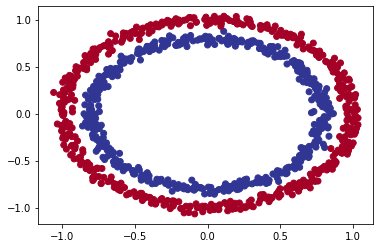

In [8]:
# Visualize the data
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

## 1.1 Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values of One Example of X: {X_sample} and the shape is: {X_sample.shape}")
print(f"Values of One Example of y: {y_sample} and the shape is: {y_sample.shape}")

Values of One Example of X: [0.75424625 0.23148074] and the shape is: (2,)
Values of One Example of y: 1 and the shape is: ()


## 1.2 Turn Data into tensors and creae train and test splits

In [11]:
import torch
torch.manual_seed(42)

In [12]:
# turn data into tensor
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# split data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
len(X_train), len(X_test)

(800, 200)

# 2. Building Model

To do so, we want to:

    1. Setup Device agnostic code
    
    2. Construct a model , subclassing nn.Module
    
    3. Define loss function and optimizer
    
    4. Create a training and test loop

In [15]:
import torch
from torch import nn

## 2.1 Make device agnostic code

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2.1 Constructing Model

* Subclass nn.Module
* Create 2 `nn.Linear()` layers that are capable in handling our data
* Define forward method that outlines the forward computation
* Instantiate an instance of our model class and send it to the target device

In [17]:
class CircleModelV1(nn.Module):
    
    def __init__(self):
        super().__init__()
        # create 2 nn.linear layers capable of handling input data
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature ( same as shape of y)
        
    def forward(self, x):
        return self.layer2(self.layer1(x))
    
# instantiate the model class and send it to target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Check which device my model sits
next(model_0.parameters()).device

device(type='cpu')

In [19]:
## Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
## Another way to create the model class
class CircleModelV0(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.two_linear_layer = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
        
    def forward(self, x):
        return self.two_linear_layer(x)
    
# instantiate the model class and send it to target device
model = CircleModelV0().to(device)
model

CircleModelV0(
  (two_linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [21]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [23]:
## Make some predictions using the random weights intially intialized
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of Predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 Labels:\n{y_test[:10]}")

Length of Predictions: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.2 Loss Function and Optimizer

* Regression - MAE, MSE
* Classification - BinaryCrossEntropy or BinaryCrossEntropyLossWithLogits or CategoricalCrossEntropy(cross entropy)

In [24]:
#loss_fn = nn.BCELoss() # requires inputs have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEwithLogistsLoss has sigmoid function built in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [25]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/ len(y_pred)) * 100
    return acc

## 3. Train Model

Steps

1. Forward Pass
2. Calculate Loss
3. Optimizer Zero grad
4. Loss Backward ( backpropagation)
5. Optimizer Step (gardient descent)

## 3.1 Going from raw logist --> Prediction Probabilities --> Prediction Labels

* Our models outputs is going to be raw **logits**
* We can convert these **logits** into prediction probabilities by passing them through some kind of activation function ( sigmoid for binary and softmtax for muticlass)
* Then we convert model's prediction probabilites to **prediction labels** by either rounding them or taking the `arg_max()` 

In [26]:
# View the first outputs of the forward pass on test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits # are logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [27]:
## Use the sigmoid activation function on model's raw logits output to convert them to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probabilities values, we need to perform a range-style rounding to them:
    
    * y_pred_prob >=0.5, y_class = 1 ( class 1)
    * y_pred_prob < 0.5, y_class = 0 ( class 0)

In [28]:
## Convert the pred probabilites into prediction class / Labels
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

## 3.2 Building training and testing loop

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epchs
epochs = 100

# put the data to the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    
    # Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turns logits -> pred probs -> pred labels
    
    # calculate loss
    # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss expects prediction proabilities as input
    #y_train)
    loss = loss_fn(y_logits, ##nn.BCEWithLogistLoss Expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    # print stuffs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}| Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69796| Acc: 51.88| Test Loss: 0.69440| Test Acc: 58.00
Epoch: 10 | Loss: 0.69590| Acc: 51.25| Test Loss: 0.69305| Test Acc: 53.00
Epoch: 20 | Loss: 0.69490| Acc: 51.62| Test Loss: 0.69254| Test Acc: 49.50
Epoch: 30 | Loss: 0.69435| Acc: 51.12| Test Loss: 0.69236| Test Acc: 49.50
Epoch: 40 | Loss: 0.69401| Acc: 50.88| Test Loss: 0.69232| Test Acc: 51.00
Epoch: 50 | Loss: 0.69378| Acc: 50.25| Test Loss: 0.69234| Test Acc: 50.00
Epoch: 60 | Loss: 0.69362| Acc: 50.00| Test Loss: 0.69239| Test Acc: 51.50
Epoch: 70 | Loss: 0.69351| Acc: 50.25| Test Loss: 0.69246| Test Acc: 51.00
Epoch: 80 | Loss: 0.69342| Acc: 49.88| Test Loss: 0.69254| Test Acc: 50.00
Epoch: 90 | Loss: 0.69336| Acc: 49.88| Test Loss: 0.69262| Test Acc: 53.00


# 4. Make Predictions

### We will download a helper function called `plot_decision_boundary`

In [30]:
import requests
from pathlib import Path

# download helper functions
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

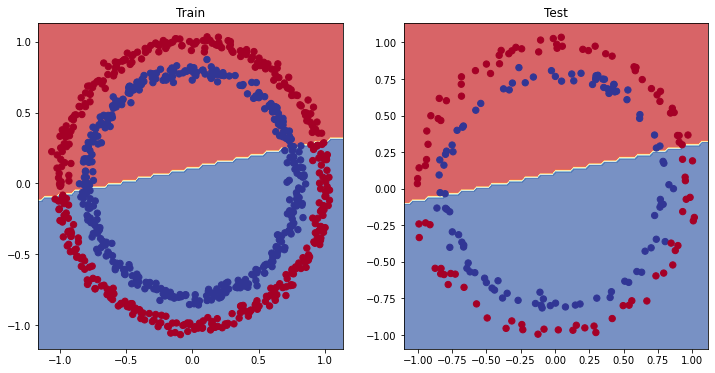

In [31]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5. Improving our Model

*Options Available - Model's Perspective - HyperParameters*

1. Add more layers - give model more chances to learn about the patterns in the data
2. Add more hidden units - go from 5 hidden units to 10 hidden units
3. Fit for longer
4. Changing the activation function
5. Change the learning rate
6. Change the loss function

Let's try to improve our model using
1. 5 -> 10 hidden units
2. Add extra layer
3. INcrease epochs

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        
        # one approach - slower
        #z = self.layer1(x)
        #z = self.layer2(z)
        #z = self.layer3(z)
        #return z
        
        # faster approach - speeds up wherever possible
        return self.layer3(self.layer2(self.layer1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
## Create a loss function and optimizer and then training and evaluation loop
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put the data to the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    #Training
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Test
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
    #print stuff
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}| Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396| Acc: 50.88| Test Loss: 0.69261| Test Acc: 51.00
Epoch: 100 | Loss: 0.69305| Acc: 50.38| Test Loss: 0.69379| Test Acc: 48.00
Epoch: 200 | Loss: 0.69299| Acc: 51.12| Test Loss: 0.69437| Test Acc: 46.00
Epoch: 300 | Loss: 0.69298| Acc: 51.62| Test Loss: 0.69458| Test Acc: 45.00
Epoch: 400 | Loss: 0.69298| Acc: 51.12| Test Loss: 0.69465| Test Acc: 46.00
Epoch: 500 | Loss: 0.69298| Acc: 51.00| Test Loss: 0.69467| Test Acc: 46.00
Epoch: 600 | Loss: 0.69298| Acc: 51.00| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 700 | Loss: 0.69298| Acc: 51.00| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 800 | Loss: 0.69298| Acc: 51.00| Test Loss: 0.69468| Test Acc: 46.00
Epoch: 900 | Loss: 0.69298| Acc: 51.00| Test Loss: 0.69468| Test Acc: 46.00


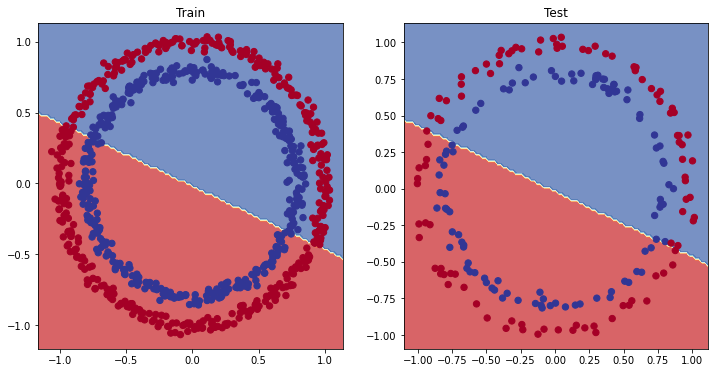

In [35]:
# Plot the decision boundary
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1  Preparing data to see if our model can fit straight line

In [36]:
## Create some data ( same as worflow data)

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression

# check data
X_regression[:10], y_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [37]:
# create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

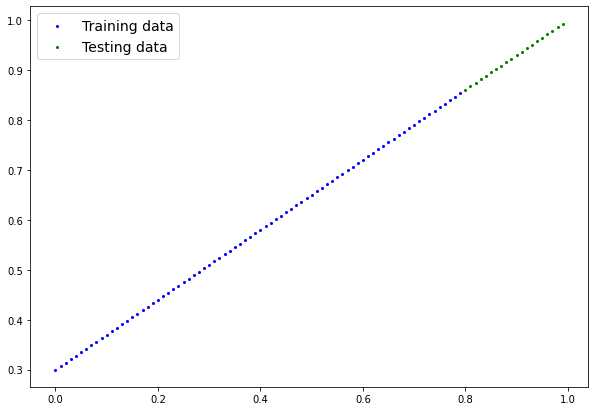

In [38]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

## 5.2 Adjust `model_1` to fit a straigt line

In [39]:
# same architecture as model_1 ( but using nn.Sequrntial)
model_2 = nn.Sequential(
        nn.Linear(in_features=1, out_features=10),
        nn.Linear(in_features=10, out_features=10),
        nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [40]:
# loss and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [41]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# loop
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # test
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # print out stuff
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986| Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858| Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533| Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137| Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964| Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940| Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903| Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878| Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840| Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798| Test Loss: 0.00360


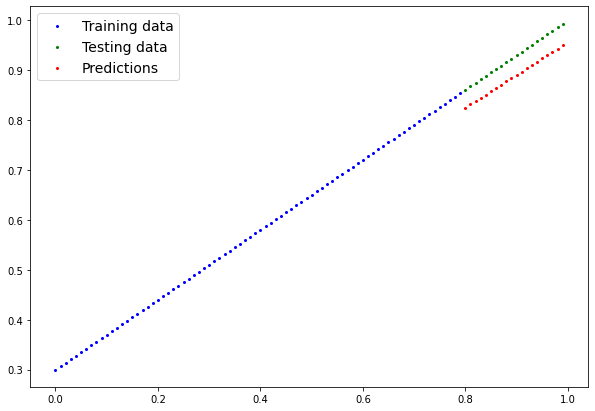

In [42]:
# turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
# PLot data and Predictions
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds)

# 6. The Missing Peice : Non-Linearity

## 6.1 recreating non-linear data ( red and blue circles)

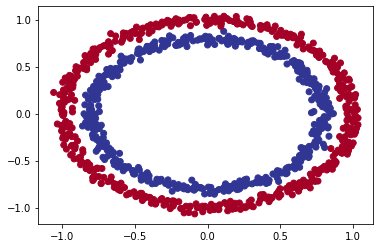

In [43]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [44]:
# convert data to tensors and then to train and test
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a Model with Non-Linearity

In [45]:
# build a model with non-linear activaion function
from torch import nn

class CircleModelV2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # where should we pt our non-linear activaion function
        # relu is a non-linear activaion fution
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
    
model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3 Train the Model

In [47]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all the data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000
for epoch in range(epochs):
    #training
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction_lables
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)
        
    # print stuff
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}| Test Loss: {test_loss:.5f}| Test Acc: {test_acc:.2f}")
    

Epoch: 0 | Loss: 0.69295| Acc: 50.00| Test Loss: 0.69319| Test Acc: 50.00
Epoch: 100 | Loss: 0.69115| Acc: 52.88| Test Loss: 0.69102| Test Acc: 52.50
Epoch: 200 | Loss: 0.68977| Acc: 53.37| Test Loss: 0.68940| Test Acc: 55.00
Epoch: 300 | Loss: 0.68795| Acc: 53.00| Test Loss: 0.68723| Test Acc: 56.00
Epoch: 400 | Loss: 0.68517| Acc: 52.75| Test Loss: 0.68411| Test Acc: 56.50
Epoch: 500 | Loss: 0.68102| Acc: 52.75| Test Loss: 0.67941| Test Acc: 56.50
Epoch: 600 | Loss: 0.67515| Acc: 54.50| Test Loss: 0.67285| Test Acc: 56.00
Epoch: 700 | Loss: 0.66659| Acc: 58.38| Test Loss: 0.66322| Test Acc: 59.00
Epoch: 800 | Loss: 0.65160| Acc: 64.00| Test Loss: 0.64757| Test Acc: 67.50
Epoch: 900 | Loss: 0.62362| Acc: 74.00| Test Loss: 0.62145| Test Acc: 79.00


## 6.4 Evaluate Models

In [49]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

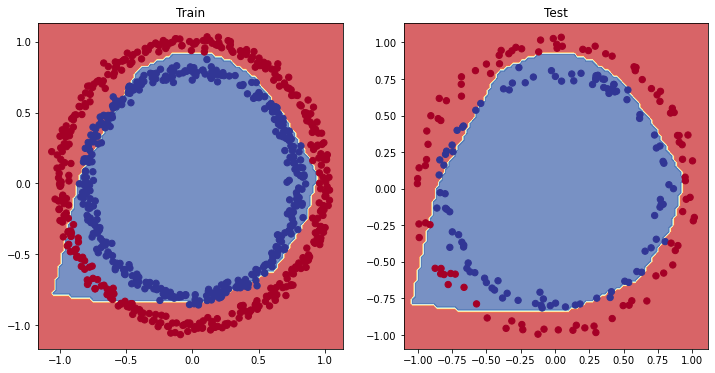

In [50]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

# 7. Replicating Non-Linear Activation Functions

## 7.1 Relu

In [51]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

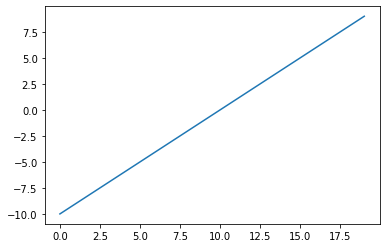

In [52]:
# Visualize this data
plt.plot(A)

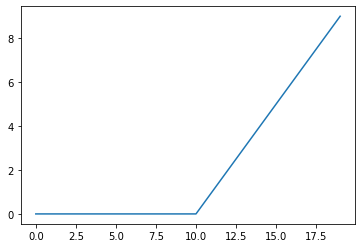

In [53]:
plt.plot(torch.relu(A))

In [54]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

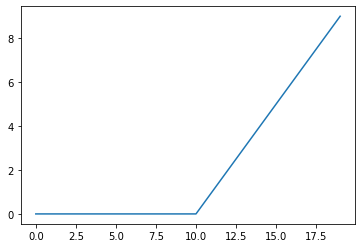

In [55]:
plt.plot(relu(A))

## 7.2 Sigmoid

In [56]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

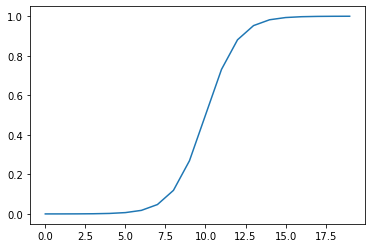

In [57]:
plt.plot(sigmoid(A))

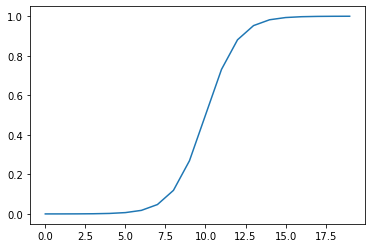

In [58]:
plt.plot(torch.sigmoid(A))